<a href="https://colab.research.google.com/github/ykitaguchi77/Laboratory_course/blob/master/10.%20Pytorch_RESNET18%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E_%E3%82%AA%E3%83%AA%E3%82%B8%E3%83%8A%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : RESNET18を用いた画像分類（自作データセットを用いた転移学習）

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


#自作データ、Early stopping

#Google driveのデータをマウント
データの位置
/content/drive/My drive/Deep_learning/dataset

In [19]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode
np.random.seed(1234)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

shutil.move("/content/train/appl", "/content/appl")
shutil.move("/content/train/stra", "/content/stra")
shutil.rmtree("/content/train")
shutil.rmtree("/content/val")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mon, 27 Jan 2025 01:56:35 +0000
replace train/appl/%E3%82%8A%E3%82%93%E3%81%94%E3%80%80%E8%A9%B0%E3%82%81%E6%94%BE%E9%A1%8C%E3%80%80%E3%82%A4%E3%83%99%E3%83%B3%E3%83%88-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
Mon, 27 Jan 2025 01:56:44 +0000
appl  checkpoint.pt  drive  sample_data  stra  train  val


#データセットをフォルダ分け

In [ ]:
"""
このような形にしたい

dog---dog1.jpg
    |-dog2.jpg
    |-dog3.jpg
    |
    |-dog300.jpg

cat---cat1.jpg
    |-cat2.jpg
    |-cat3.jpg
    |
    |-cat300.jpg

↓↓

train---dog---dog1.jpg
      |     |-dog2.jpg
      |     |
      |     |-dog299.jpg
      |
      |-cat---cat1.jpg
            |-cat2.jpg
            |
            |-cat298.jpg

val-----dog---dog3.jpg
      |     |-dog4.jpg
      |     |
      |     |-dog300.jpg
      |
      |-cat---cat3.jpg
            |-cat4.jpg
            |
            |-cat300.jpg

"""

In [ ]:
#trainとvalにランダムに分けるスクリプト

import glob
import os
import random
import shutil
from sklearn.model_selection import train_test_split

class_names = ["appl", "stra"] ###←ここを変更してください
parent_dir = f'/content' ###←ここを変更してください

for class_name in class_names:

    # location of the dataset
    orig_dir = f'{parent_dir}/{class_name}'

    # get the list of all files in the folder
    all_files = glob.glob(f"{orig_dir}/*")

    print(f"len_all_files: {len(all_files)}")

    # split the list into train and validation sets
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=0)

    # create the train and validation folders if they don't exist
    train_folder = f'/content/train/{class_name}'
    val_folder = f'/content/val/{class_name}'
    if os.path.exists(train_folder):
        shutil.rmtree(train_folder)
    os.makedirs(train_folder)
    if os.path.exists(val_folder):
        shutil.rmtree(val_folder)
    os.makedirs(val_folder)

    # copy the files from the dataset folder to the train and validation folders
    for file in train_files:
        new_location = f"{train_folder}/{os.path.basename(file)}"
        shutil.copy(file, new_location)

    for file in val_files:
        new_location = os.path.join(val_folder, os.path.basename(file))
        shutil.copy(file, new_location)

#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。訓練用データセットと評価用データセットは4:1ぐらいにします。

In [ ]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:201
stra_train:201
appl_val:51
stra_val:51
training data set_total：402
validating data set_total：102


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#少数の画像を可視化する

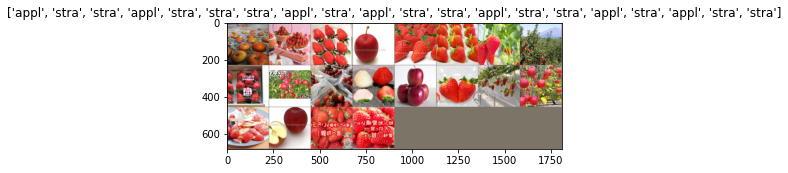

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Define the Early Stopping Class

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする<br>
ベスト・モデルをセーブする<br>

In [ ]:
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

      # early_stopping needs the validation loss to check if it has decresed,
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
モデルをロードして最後の完全結合層をリセットします。<br>
※pretrained = False　→事前訓練していない状態になります<br>
※pretrained = True　→事前訓練しされた状態

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [ ]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

train Loss: 0.4102 Acc: 0.8085
val Loss: 0.1597 Acc: 0.9510
Validation loss decreased (inf --> 0.159692).  Saving model ...

Epoch 1/24
----------
train Loss: 0.1495 Acc: 0.9478
val Loss: 0.1152 Acc: 0.9706
Validation loss decreased (0.159692 --> 0.115235).  Saving model ...

Epoch 2/24
----------
train Loss: 0.0815 Acc: 0.9776
val Loss: 0.0915 Acc: 0.9706
Validation loss decreased (0.115235 --> 0.091475).  Saving model ...

Epoch 3/24
----------
train Loss: 0.1053 Acc: 0.9627
val Loss: 0.0935 Acc: 0.9804
EarlyStopping counter: 1 out of 5

Epoch 4/24
----------
train Loss: 0.0740 Acc: 0.9826
val Loss: 0.0966 Acc: 0.9706
EarlyStopping counter: 2 out of 5

Epoch 5/24
----------
train Loss: 0.0770 Acc: 0.9726
val Loss: 0.0799 Acc: 0.9804
Validation loss decreased (0.091475 --> 0.079946).  Saving model ...

Epoch 6/24
----------
train Loss: 0.0503 Acc: 0.9876
val Loss: 0.0845 Acc: 0.9804
EarlyStopping counter: 1 out of 5

Epoch 7/24
----------
train Loss: 0.0596 Acc: 0.9801
val Loss: 0.087

#訓練結果のグラフ化

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
visualize_model(model_ft)

#Test datasetにおける正解率を（改めて）計算

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

# 正解ラベルと予測結果を格納する変数を用意する
y_true = []
y_pred = []

class_names = ["appl", "stra"]
show_image = True
reverse_augmentation = True


# def de_normalize(array):
#     for t, m, s in zip(array, mean, std):
#         t.mul_(s).add_(m)
#     return array
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



# モデルを評価するデータセットに対して、正解率を計算する
with torch.no_grad():
    for data, target in dataloaders["val"]:
        # dataをモデルに入力し、予測結果を出力する
        data, target = data.to(device), target.to(device)
        outputs = model_ft(data)

        # 予測結果から最も確信度が高いクラスを選ぶ
        _, predicted = torch.max(outputs.data, 1)

        # 正解ラベルと予測結果を格納する
        y_true.extend(target.tolist())
        y_pred.extend(predicted.tolist())

        # if show_image == True:
        #     data = data.cpu().detach().numpy().copy()
        #     data = data / 2 + 0.5
        #     plt.imshow(data)
        #     plt.show()

        if show_image == True:
            # Convert the PyTorch tensor to a numpy array
            data = data.cpu().permute(0, 2, 3, 1).detach().numpy().copy()
            if reverse_augmentation == True:
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                data *= std
                data += mean
                data *= 255
                data = np.clip(data, 0, 255).astype(np.uint8)
            else:
                data = np.clip(data, 0, 1)



            batch_size = 20
            for i in range(batch_size):
                try: #batch size端数のエラー回避
                    plt.imshow(data[i])
                    plt.show()
                    print(f"label: {class_names[y_true[i]]}, pred: {class_names[y_pred[i]]}")
                    print("")
                except:
                    pass

# 混同行列を計算する
cm = confusion_matrix(y_true, y_pred)

# 各クラスの正解率を計算する
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / sum(cm[i, :])
    print('Class {} Accuracy: {:.2f}%'.format(class_name, class_accuracy * 100))

#モデルの保存

In [ ]:
PATH = '/content/drive/My Drive/AI_laboratory_course/classification.pth'
torch.save(model_ft.state_dict(), PATH)

# Load model and inference

In [ ]:
# prompt: モデルのロード

import torch
import torch.nn as nn

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルの定義 (ResNet18 を例に)
model = models.resnet18(pretrained=False)  # 事前学習済みモデルを使用しない場合
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 出力層を2クラス分類用に変更

# モデルのロード
PATH = '/content/drive/My Drive/AI_laboratory_course/classification.pth'
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import torch.nn as nn


# 画像の前処理を定義
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# クラスの定義
classes = ["apple", "strawberry"] ##変更してください

# テスト用画像の読み込みと前処理
image_path = "/content/stra/large-f549055e1c98b1a43c2a3f7eb7320a6b.jpg" ##変更してください
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0).to(device)

# 元画像の表示
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# 推論の実行
with torch.no_grad():
    outputs = model(image_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted = torch.argmax(probabilities, dim=1)

    print(f"outputs: {outputs}")
    print(f"probabilities: {probabilities}")
    print(f"predicted: {predicted}")


    # 予測結果の表示（top1のみ）
    pred_class = classes[predicted.item()]
    pred_prob = probabilities[0][predicted.item()].item() * 100
    print(f"predicted.item(): {predicted.item()}")
    print(f"\nPrediction: {pred_class} ({pred_prob:.2f}%)")

# 前処理後の画像の表示
img_normalized = image_tensor[0].cpu().numpy()
img_normalized = np.transpose(img_normalized, (1, 2, 0))
img_normalized = (img_normalized * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
img_normalized = np.clip(img_normalized, 0, 1)

plt.subplot(1, 2, 2)
plt.imshow(img_normalized)
plt.title('Preprocessed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

#演習
1. Pretrained model = Trueに変更して、転移学習をしてみましょう
2. 自作のデータセットを用いて分類を行ってみましょう
3. パラメータ（batch size、lr、Patienceなど）をいじってみて学習効率の変化を観察しましょう